In [1]:
import numpy as np
import pandas as pd
import os
# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Dropout, Embedding, Flatten, MaxPooling1D, Conv1D
from tensorflow.keras.utils import set_random_seed
# Preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Train test split
from sklearn.model_selection import train_test_split

In [2]:
# Read glove embeddings and data
filename='../data/glove.6B.50d.txt'
embeddings_index = dict()
with open(filename, encoding="utf8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
file.close()

data = pd.read_csv('../data/imdb_movie.zip')

In [3]:
# Split into train and test data
labels = data['label'].array
reviews = data['text'].array
x_train, x_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, stratify=labels, random_state=1)

In [4]:
# Tokenize and pad the train data
t = Tokenizer()
t.fit_on_texts(x_train)
vocab_size = len(t.word_index) + 1
encoded_x = t.texts_to_sequences(x_train)

padded_x = pad_sequences(encoded_x, padding='post')
input_length = padded_x.shape[1]
print(vocab_size, input_length)

101485 2332


In [5]:
# Tokenize and pad the test data with the same tokenizer and pad the same length as train data
encoded_x_test = t.texts_to_sequences(x_test)
padded_x_test = pad_sequences(encoded_x_test, maxlen=input_length, padding='post')
print(padded_x.shape)
print(padded_x_test.shape)

(32000, 2332)
(8000, 2332)


In [6]:
# Create embedding matrix based on train data
# This becomes part of the model, cannot use glove embeddings for words outside train data
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [8]:
# Define model
x = padded_x.astype(np.float32)
y = y_train.astype(np.float32)
set_random_seed(1)

model = Sequential()
e = Embedding(input_dim=vocab_size, 
              output_dim=50, 
              weights=[embedding_matrix], 
              input_length=input_length, 
              trainable=False)
model.add(e)
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
print(model.summary())
history = model.fit(x, y, epochs=5, batch_size=64, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2332, 50)          5074250   
                                                                 
 conv1d (Conv1D)             (None, 2332, 32)          4832      
                                                                 
 max_pooling1d (MaxPooling1  (None, 1166, 32)          0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                      

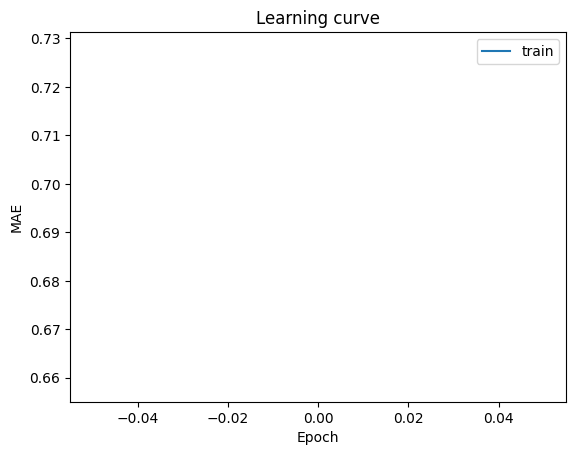

In [9]:
from matplotlib import pyplot

# plot model
def plot_learning(callback):
    pyplot.title('Learning curve')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('MAE')
    pyplot.plot(callback.history['loss'], label='train')
    pyplot.legend()
    pyplot.show()
    
plot_learning(history)

In [10]:
model.save('models/model_v3.keras')

In [11]:
# Evaluate on test data
x_test = padded_x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

250/250 [==============================] - 60s 237ms/step - loss: nan - accuracy: 0.5005
test loss, test acc: [nan, 0.5005000233650208]
